<a href="https://colab.research.google.com/github/Xixaus/Standard_add/blob/main/Standardni_pridavek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda standardního přídavku


- Program slouží k výpočtu koncentrace vzorku pomocí metody standardního přídavku nebo standardního přídavku za konstantního objemu a vytvoření příslušného grafu
- Nejdříve se připojte k hostujícímu prostředí v pravé horní části (musíte být přihlášený ke Google účtu)
- Poté zadejte do první buňky hodnoty !podle návodu!, výpočet a graf vygenerujete spuštěním druhé buňky tlačítkem ▶ v levém horním rohu vedle nadpisu
- Při prvním spuštění se instaluje potřebná knihovna, tak to trvá déle, další výpočty jsou okamžité

- !!!Všechny objemy zadávejte ve stejných jednotkách, jednotlivá měření stejného roztoku oddělujte pomocí středníku (;), odezvy a objemy jednotlivých standardů pomocí lomítka (/)!!!




- V_unit: zadejte jednotku objemu, ve které budete zadávat všechny objemy (bez indexů)
- R_unit: zadejte jednotku měřené veličiny, která bude na y ose v grafu
- X_axys_name: zvolte v čem chcete mít X osu
- V_flask: zadejte objem odměrné baňky, v případě nezadání bude koncentrace vypočtena metodou přídavku standardu za zvýšení objemu
- V_sample: zadejte objem odpiptovaného vzorku, který je odpipetován do odměrné baňky nebo se k němu přidává standard
- R_sample: zadejte odezvy vzorku (např: 0.200; 0.204; 0.206)
- c_standard: zadejte koncentraci standardu
- c_unit: zadejte jednotku koncentrace standardu (bez indexů)
- V_standards: zadejte objemy přidaných standardů (např: 2.0 / 4.0 / 6.0 / 8.0 / 10.0)
- R_standard: zadejte odezvy odezvy standardů (např: 0.365; 0.360; 0.375 / 0.514; 0.51; 0.518)
- Pomocí volby Save_graph můžete graf uložit ve formátu .pdf, který se nachází ve složce soubory v levé části obrazovky pod ikonou 📁 s názvem graph.pdf. Dvojklikem soubor stáhnete




In [73]:
#@title Vstupní hodnoty { run: "auto", vertical-output: true }
V_unit = 'ml' #@param {type:"string"}
R_unit = "mV.s" #@param {type:"string"}
X_axys_name = "Pridany objem standardu" #@param ["Zvysena koncentrace", "Pridany objem standardu"]
V_flask = 10#@param {type:"number"}
V_sample =  1#@param {type:"number"}
R_sample = "59831;56474;53063" #@param {type:"string"}
c_standard =  50#@param {type:"number"}
c_unit = '%' #@param {type:"string"}
V_standards = "0.01"#@param {type:"string"}
R_standards = "131243,2;133514;133647"#@param {type:"string"}
Save_graph = False #@param {type:"boolean"}

y = 7.635e+06x + 5.646e+04
R²: 0.9970
Koncentrace analytu: 0.37 %
Směrodatná odchylka: 0.018 %
Interval spolehlivosti: 0.039 %


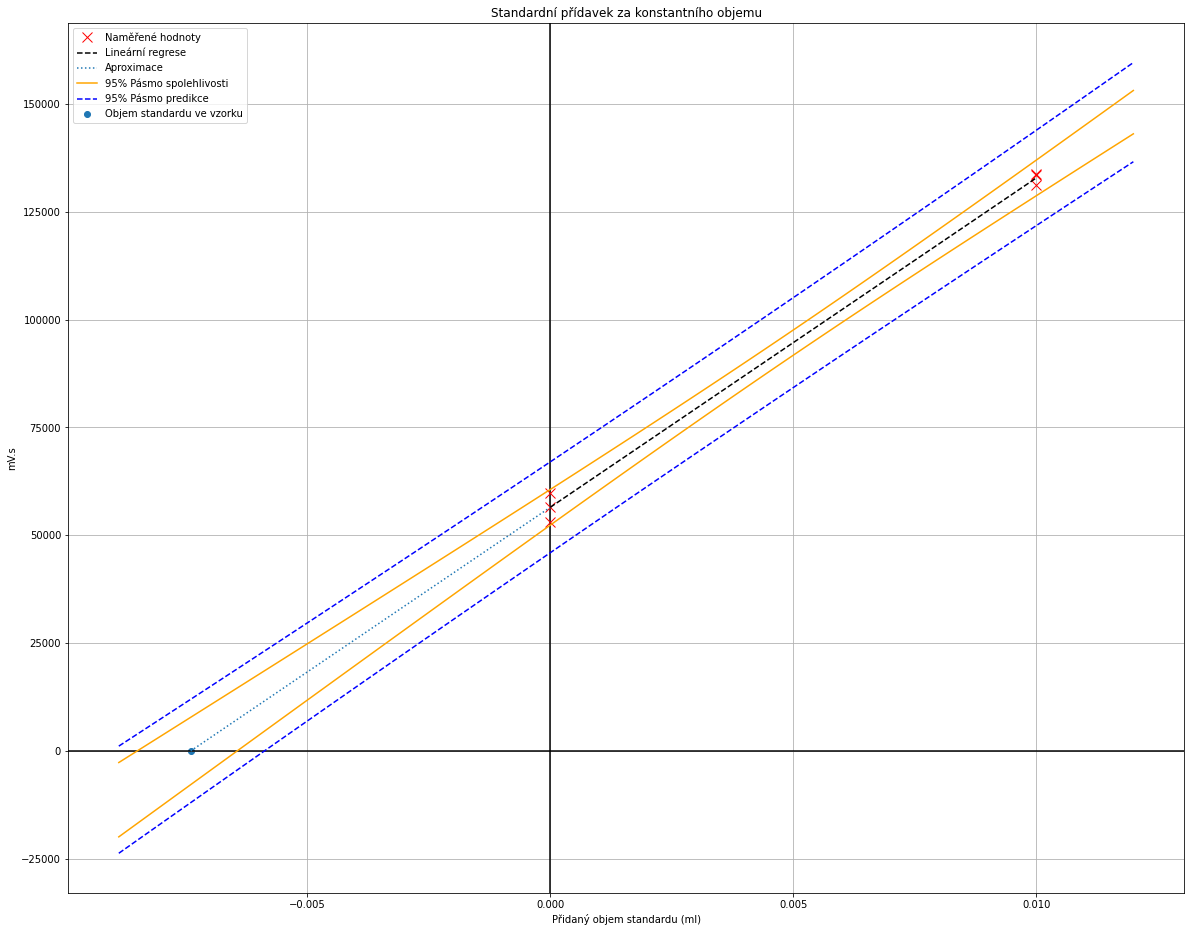

In [74]:
#@title Graf s výsledkem
import os
import numpy as np
import math
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import clear_output
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    !pip install uncertainties
    clear_output(wait=True)
    import uncertainties.unumpy as unp
    import uncertainties as unc

#import knihoven

def data_extract(V_standards, R_standards, R_sample):
    R_st2, R_st3, x, X, y = [], [], [], [], [] #vytvoření prázdných listů

    R_st1 = (R_standards.replace(",", ".")).split("/")
    V_st1 = (V_standards.replace(",", ".")).split("/")
    R_sa1 = (R_sample.replace(",", ".")).split(";") #separace vstupních stringů na seznamy podle dělécího znaménka a převedení , na .

    V_st2 = list(np.zeros((len(R_sa1)), dtype='uint8'))

    for i in range(len(R_st1)): #rozseparování stringů odezev na seznamy
      R_st2.append(R_st1[i].split(";"))

    for i in range(len(R_st2)): #znásobení objemů standardů podle počtu odezev a přidání k 0 hodnotám
      for ii in range(len(R_st2[i])):
        V_st2.append(V_st1[i])

    for i in range(len(R_st2)): #převedení vnořených seznamů do jednoho seznamu
      R_st3 += R_st2[i]

    X = [float(i) for i in (V_st2)] #převedení objemů na float
    y = [float(i) for i in (R_sa1 + R_st3)] # spojení odezev vzorku a standardů a převedení na float

    return (X, x, y)

X, x, y = data_extract(V_standards, R_standards, R_sample) #extrakce dat ze vstupů

if V_flask == None: #Volba konstatního objemu nebo přídavku
  graph_name = "Standardní přídavek"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x = [(X[i]*c_standard)/(V_sample + X[i]) for i in range(len(X))]
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
  else:
    x = X
    x_name = f"Přidaný objem standardu ({V_unit})"

else:
  graph_name = "Standardní přídavek za konstantního objemu"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x = [X[i]*(c_standard/V_flask) for i in range(len(X))] #přepočtení objemů standardu na koncentraci v odměrné baňce
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
  else:
    x = X
    x_name = f"Přidaný objem standardu ({V_unit})"

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)
poly1d_fn = np.poly1d(popt) #převedení na rovnici regrese
R2 = (np.corrcoef(x, y)[0,1])**2 #výpočet korelačního koeficientu
a,b = unc.correlated_values(popt, pcov)

def std_reg(R2, x, y): #Funkce pro výpočet směrodatné odchylky
  if R2 == 1: # v případě dokonalé korelace, zastavení výpočtu odchylky
    Sx = 0
  else:
    x_ave = sum(x)/len(x)
    y_ave = sum(y)/len(y) #výpočet průměrů

    S_rezid = 0
    for i in range(len(x)):
      S_rezid += (y[i]-popt[0]*x[i]-popt[1])**2 #Součet druhých mocnin reziduí

    sx = 0
    for i in range(len(x)): 
      sx += (x[i]-x_ave)**2 #čitatel kovarience xx

    Sy = math.sqrt(S_rezid/(len(x)-2)) #Směrodatná odchylka regrese
    Sx = (Sy/abs(popt[0]))*math.sqrt((1/len(x))+(y_ave**2/((popt[0]**2)*sx))) #směrodatná odchylka výsledku

    return(Sx)

Sx = std_reg(R2, x, y) #Výpočet smerodatné odchylky

sample = popt[1]/popt[0] #vypočtení množství standardu/koncentrace vzorku

if V_flask == None: #výpočet koncetrace v případě volby metody standardního přídavku
  if X_axys_name == "Zvysena koncentrace":
    final_sample = sample #výpočet koncentrace vzorku
    final_sample_st_dev = Sx
    sample_name = "Zvýšená koncentrace roztoku vzorku"
  else:
    final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
    final_sample_st_dev = Sx * c_standard / V_sample
    sample_name = "Objem standardu ve vzorku"

else: #výpočet koncetrace v případě volby metody standardního přídavku za konstantního objemu
  if X_axys_name == "Zvysena koncentrace":
    final_sample = sample * V_flask / V_sample #výpočet koncentrace vzorku
    final_sample_st_dev = Sx * V_flask / V_sample
    sample_name = "Koncetrace roztoku vzorku"
  else:
    final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
    final_sample_st_dev = Sx * c_standard / V_sample
    sample_name = "Objem standardu ve vzorku"

if R2 != 1:
  final_sample_con_int = final_sample_st_dev * scipy.stats.t.ppf(q=0.95,df=(len(x)-2)) #výpočet intervalu spolehlivosti 0,05

x.insert(0, -sample) #přidání koncentrace/objemu standardu ve vzorku
y.insert(0, 0) #přidaní nulové hodnoty na začátek seznamu

px = np.linspace(x[0]*1.2, x[-1]*1.2, 100) #Vygenerování bodů pro znázornění pásem
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95): #funkce pro výpočet bodů preddikčního pásma
    alpha = 1.0 - conf    # significance
    N = (xd.size) - 2      # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = scipy.stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, np.array(x), np.array(y), popt, f, conf=0.95) #vygenerování bodů predikčního pásma
tinv = lambda p, df: abs(t.ppf(p/2, df))

plt.grid() #nastavení parametrů grafu
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(x_name)
plt.ylabel(R_unit)
plt.title(graph_name)
plt.rcParams["figure.figsize"] = (20,16)



plt.plot(x[1:], y[1:],"yo", marker = "x", c = "red", markersize = 10, label="Naměřené hodnoty") #vložení a nastavení hodnot v grafu
plt.scatter(x[0], y[0], marker="o", label= sample_name)
plt.plot(x[1:], poly1d_fn(x[1:]), '--k',label="Lineární regrese")
plt.plot(x[:2], poly1d_fn(x[:2]), ls = ':', label="Aproximace")

plt.plot(px, nom - tinv(0.05, len(x)-3) * std, c='orange', label='95% Pásmo spolehlivosti')
plt.plot(px, nom + tinv(0.05, len(x)-3) * std, c='orange')

plt.plot(px, lpb, 'k--',c='blue', label='95% Pásmo predikce') 
plt.plot(px, upb, 'k--', c='blue')

plt.legend(loc='best')

print (f"y = {popt[0]:.3e}x + {popt[1]:.3e}")
print (f"R\u00B2: {R2:.4f}")
print (f"Koncentrace analytu: {final_sample:.3} {c_unit}")
if R2 != 1: # v případě dokonalé korelace, nevypsání odchylky a intervalu spolehlivosti
  print (f"Směrodatná odchylka: {final_sample_st_dev:.2} {c_unit}")
  print (f"Interval spolehlivosti: {final_sample_con_int:.2} {c_unit}")

if Save_graph is False:
  plt.show()
  
else:
  plt.savefig("graph.pdf", bbox_inches="tight")